In [1]:
import numpy as np
import pylab as pl

## 图像处理-ndimage

### 形态学图像处理

In [2]:
import numpy as np

def expand_image(img, value, out=None, size = 10):
    if out is None:
        w, h = img.shape
        out = np.zeros((w*size, h*size),dtype=np.uint8)
    
    tmp = np.repeat(np.repeat(img,size,0),size,1)
    out[:,:] = np.where(tmp, value, out)
    out[::size,:] = 0
    out[:,::size] = 0
    return out
    
def show_image(*imgs): 
    for idx, img in enumerate(imgs, 1):
        ax = pl.subplot(1, len(imgs), idx)
        pl.imshow(img, cmap="gray")   
        ax.set_axis_off()    
    pl.subplots_adjust(0.02, 0, 0.98, 1, 0.02, 0)        

#### 膨胀和腐蚀

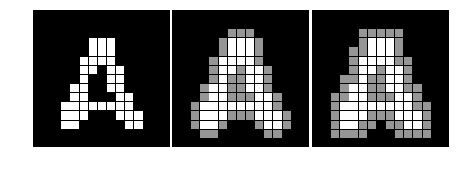

In [3]:
#%fig=四连通和八连通的膨胀运算
from scipy.ndimage import morphology

def dilation_demo(a, structure=None):
    b = morphology.binary_dilation(a, structure)
    img = expand_image(a, 255)
    return expand_image(np.logical_xor(a,b), 150, out=img)

a = pl.imread("scipy_morphology_demo.png")[:,:,0].astype(np.uint8)
img1 = expand_image(a, 255)

img2 = dilation_demo(a)
img3 = dilation_demo(a, [[1,1,1],[1,1,1],[1,1,1]])
show_image(img1, img2, img3)

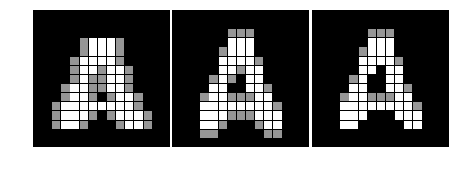

In [4]:
#%fig=不同结构元素的膨胀效果
img4 = dilation_demo(a, [[0,0,0],[1,1,1],[0,0,0]])
img5 = dilation_demo(a, [[0,1,0],[0,1,0],[0,1,0]])
img6 = dilation_demo(a, [[0,1,0],[0,1,0],[0,0,0]])
show_image(img4, img5, img6)

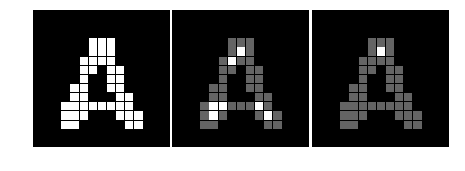

In [5]:
#%fig=四连通和八连通的腐蚀运算
def erosion_demo(a, structure=None):
    b = morphology.binary_erosion(a, structure)
    img = expand_image(a, 255)
    return expand_image(np.logical_xor(a,b), 100, out=img)

img1 = expand_image(a, 255)
img2 = erosion_demo(a)
img3 = erosion_demo(a, [[1,1,1],[1,1,1],[1,1,1]])
show_image(img1, img2, img3)

#### Hit和Miss

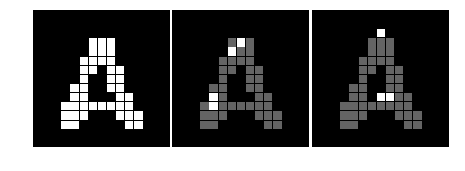

In [6]:
#%fig=Hit和Miss运算
def hitmiss_demo(a, structure1, structure2):
    b = morphology.binary_hit_or_miss(a, structure1, structure2)
    img = expand_image(a, 100)
    return expand_image(b, 255, out=img)

img1 = expand_image(a, 255)

img2 = hitmiss_demo(a, [[0,0,0],[0,1,0],[1,1,1]], [[1,0,0],[0,0,0],[0,0,0]])
img3 = hitmiss_demo(a, [[0,0,0],[0,0,0],[1,1,1]], [[1,0,0],[0,1,0],[0,0,0]])

show_image(img1, img2, img3)

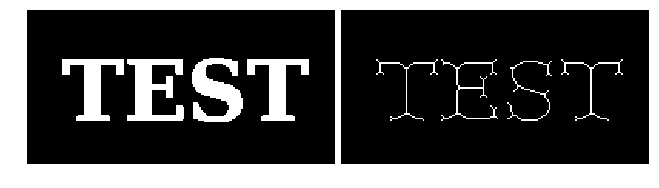

In [7]:
#%fig=使用Hit和Miss进行细线化运算
def skeletonize(img):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]]) #❶
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]]) 
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]]) 
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])    
    hit_list = [] 
    miss_list = []
    for k in range(4): #❷
        hit_list.append(np.rot90(h1, k))
        hit_list.append(np.rot90(h2, k))
        miss_list.append(np.rot90(m1, k))
        miss_list.append(np.rot90(m2, k))    
    img = img.copy()
    while True:
        last = img
        for hit, miss in zip(hit_list, miss_list): 
            hm = morphology.binary_hit_or_miss(img, hit, miss) #❸
            # 从图像中删除hit_or_miss所得到的白色点
            img = np.logical_and(img, np.logical_not(hm)) #❹
        # 如果处理之后的图像和处理前的图像相同，则结束处理
        if np.all(img == last): #❺
            break
    return img

a = pl.imread("scipy_morphology_demo2.png")[:,:,0].astype(np.uint8)
b = skeletonize(a)
#%hide
_, (ax1, ax2) = pl.subplots(1, 2, figsize=(9, 3))
ax1.imshow(a, cmap="gray", interpolation="nearest")
ax2.imshow(b, cmap="gray", interpolation="nearest")
ax1.set_axis_off()
ax2.set_axis_off()
pl.subplots_adjust(0.02, 0, 0.98, 1, 0.02, 0)

### 图像分割

In [8]:
squares = pl.imread("suqares.jpg")
squares = (squares[:,:,0] < 200).astype(np.uint8) 

In [9]:
from scipy.ndimage import morphology
squares_dt = morphology.distance_transform_cdt(squares)
print ("各种距离值", np.unique(squares_dt))

各种距离值 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [10]:
squares_core = (squares_dt > 8).astype(np.uint8)

In [11]:
from scipy.ndimage.measurements import label, center_of_mass

def random_palette(labels, count, seed=1):
    np.random.seed(seed)
    palette = np.random.rand(count+1, 3)
    palette[0,:] = 0
    return palette[labels]

labels, count = label(squares_core)
h, w = labels.shape
centers = np.array(center_of_mass(labels, labels, index=range(1, count+1)), np.int)
cores = random_palette(labels, count)

In [12]:
index = morphology.distance_transform_cdt(1-squares_core, 
                                          return_distances=False, 
                                          return_indices=True) #❶
near_labels = labels[index[0], index[1]] #❷

mask = (squares - squares_core).astype(bool)
labels2 = labels.copy()
labels2[mask] = near_labels[mask] #❸
separated = random_palette(labels2, count)

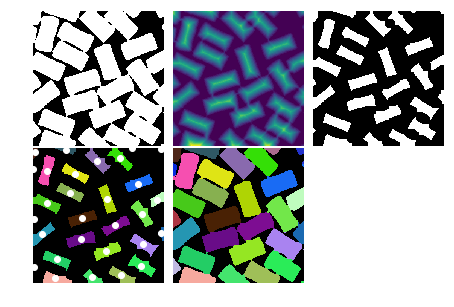

In [13]:
#%figonly=矩形区域分割算法各个步骤的输出图像
fig, axes = pl.subplots(2, 3, figsize=(7.5, 5.0), )
fig.delaxes(axes[1, 2])
axes[0, 0].imshow(squares, cmap="gray");
axes[0, 1].imshow(squares_dt)
axes[0, 2].imshow(squares_core, cmap="gray")
ax = axes[1, 0]
ax.imshow(cores)
center_y, center_x = centers.T
ax.plot(center_x, center_y, "o", color="white")
ax.set_xlim(0, w)
ax.set_ylim(h, 0)

axes[1, 1].imshow(separated)

for ax in axes.ravel():
    ax.axis("off")
    
fig.subplots_adjust(wspace=0.01, hspace=0.01)